https://www.captum.ai/tutorials/Resnet_TorchVision_Interpret

In [127]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [128]:
import sys 
sys.path.insert( 0, '../..' )

In [129]:
# ---- My utils ----
from models import *
from utils.train_arguments import *
from utils.utils_data import *
from utils.utils_training import *

### Load model

In [130]:
args.model_name = "resnet18"
args.pretrained = True
model_checkpoint = "model_best_accuracy.pt"

In [131]:
model = model_selector(args.model_name, num_classes=len(LABELS2TARGETS), pretrained=args.pretrained)
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model.load_state_dict(torch.load(model_checkpoint))
model = model.eval()

Pretrained-> Remember at end: transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm

### Load data

In [132]:
args.img_size = 256
args.crop_size = 224

args.batch_size = 1
args.validation_size = 0.15
args.get_path = True

In [133]:
if args.data_augmentation:
    train_aug = [
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.RandomCrop((args.crop_size, args.crop_size)),
        transforms.RandomHorizontalFlip(0.5),  # because this method is used for PIL Image dtype
        transforms.RandomVerticalFlip(0.5),  # because this method is used for PIL Image dtype
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ]
else:
    train_aug = [
        transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
        transforms.Resize((args.img_size, args.img_size)),
        transforms.CenterCrop((args.crop_size, args.crop_size)),
        transforms.ToTensor(),  # because inpus dtype is PIL Image
    ]

val_aug = [
    transforms.ToPILImage(),  # because the input dtype is numpy.ndarray
    transforms.Resize((args.img_size, args.img_size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.ToTensor(),  # because inpus dtype is PIL Image
]

if args.pretrained:
    train_aug.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    val_aug.append(transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))

# data_partition='', data_augmentation=None, validation_size=0.15, seed=42
train_dataset = SIMEPU_Dataset(data_partition='train', transform=transforms.Compose(train_aug), 
                               validation_size=args.validation_size, get_path=args.get_path)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=True)

val_dataset = SIMEPU_Dataset(data_partition='validation', transform=transforms.Compose(val_aug), 
                             validation_size=args.validation_size, get_path=args.get_path)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, pin_memory=True, shuffle=True)

### Predict

In [210]:
batch = next(iter(val_loader))
sample = batch[0]
target = batch[1]
sample_path = batch[2][0]

output = model(sample)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = TARGETS2LABELS[int(pred_label_idx.item())]

print("Real: {}".format(TARGETS2LABELS[target.item()]))
print("Predicted: {}".format(predicted_label))

Real: Alcantarillado
Predicted: Alcantarillado


In [211]:
img = Image.open(sample_path)

val_aug = [
    transforms.Resize((args.img_size, args.img_size)),
    transforms.CenterCrop((args.crop_size, args.crop_size)),
    transforms.ToTensor(),  # because inpus dtype is PIL Image
]

transformed_img = transforms.Compose(val_aug)(img)

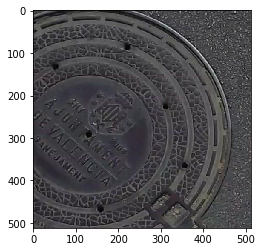

In [212]:
plt.imshow(img)

### Attributions visualizer

In [213]:
if not os.path.exists(TARGETS2LABELS[target.item()]):
    os.makedirs(TARGETS2LABELS[target.item()])

Computes attributions using Integrated Gradients and visualizes them on the image. Integrated gradients computes the integral of the gradients of the output of the model for the predicted class pred_label_idx with respect to the input image pixels along the path from the black image to our input image.

Real: Alcantarillado
Predicted: Alcantarillado (Confidence 100.000000%)


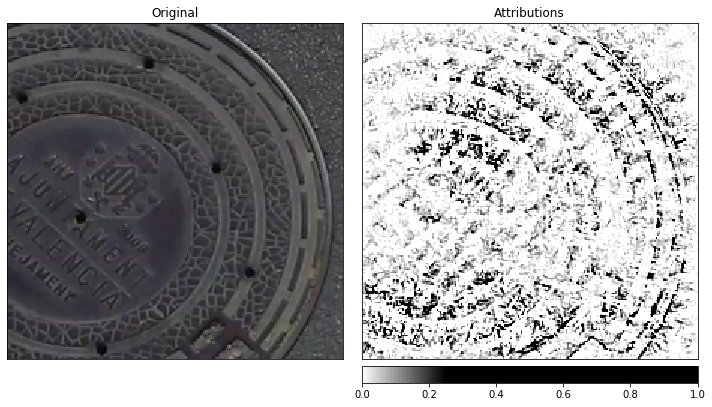

In [214]:
print("Real: {}".format(TARGETS2LABELS[target.item()]))
print("Predicted: {} (Confidence {:.6f}%)".format(predicted_label, prediction_score.squeeze().item()*100))

integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(sample, target=pred_label_idx, n_steps=200)

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


comp = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             cmap=default_cmap,
                             show_colorbar=True,  fig_size=(10, 10),
                             signs=['all','positive'], titles=["Original","Attributions"],
                             outlier_perc=1)

fig = comp[1][0].get_figure()
fig.suptitle("Linnear Segmented - {}".format(TARGETS2LABELS[target.item()]))
fig.savefig("{}/linear_segmented.png".format(TARGETS2LABELS[target.item()]), transparent=True, dpi=400)

Computes attributions using Integrated Gradients and smoothens them across multiple images generated by noise tunnel. The latter adds gaussing noise with a std equals to one, 10 times (n_samples=10) to the input (sample). Ultimately, noise tunnel smoothens the attributions across n_samples noisy samples using smoothgrad_sq technique. smoothgrad_sq represents the mean of the squared attributions across n_samples samples

Real: Alcantarillado
Predicted: Alcantarillado (Confidence 100.000000%)


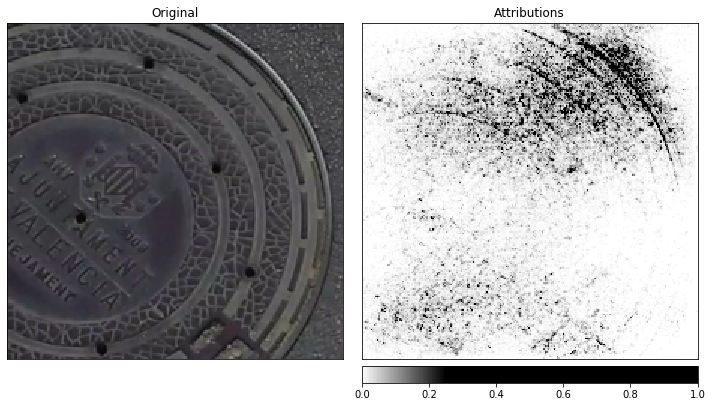

In [215]:
print("Real: {}".format(TARGETS2LABELS[target.item()]))
print("Predicted: {} (Confidence {:.6f}%)".format(predicted_label, prediction_score.squeeze().item()*100))

noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(sample, n_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)

comp = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"], fig_size=(10, 10),
                                      cmap=default_cmap, titles=["Original","Attributions"],
                                      show_colorbar=True, use_pyplot=True)

fig = comp[1][0].get_figure()
fig.suptitle("Noise Tunnel - {}".format(TARGETS2LABELS[target.item()]))
fig.savefig("{}/noise_tunnel.png".format(TARGETS2LABELS[target.item()]), transparent=True, dpi=400)

GradientShap is a linear explanation model which uses a distribution of reference samples (in this case two images) to explain predictions of the model. It computes the expectation of gradients for an input which was chosen randomly between the input and a baseline. The baseline is also chosen randomly from given baseline distribution.

Real: Grietas en forma de piel de cocodrilo
Predicted: Grietas en forma de piel de cocodrilo (Confidence 99.998498%)


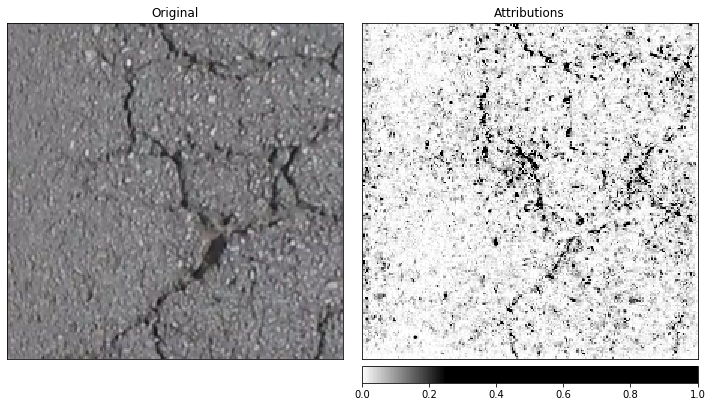

In [126]:
print("Real: {}".format(TARGETS2LABELS[target.item()]))
print("Predicted: {} (Confidence {:.6f}%)".format(predicted_label, prediction_score.squeeze().item()*100))

torch.manual_seed(0)
np.random.seed(0)

gradient_shap = GradientShap(model)

# Defining baseline distribution of images
rand_img_dist = torch.cat([sample * 0, sample * 255])

attributions_gs = gradient_shap.attribute(sample,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
comp = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],  fig_size=(10, 10),
                                      cmap=default_cmap, titles=["Original","Attributions"],
                                      show_colorbar=True)

fig = comp[1][0].get_figure()
fig.suptitle("Gradient Shap - {}".format(TARGETS2LABELS[target.item()]))
fig.savefig("{}/gradient_shap.png".format(TARGETS2LABELS[target.item()]), transparent=True, dpi=400)